The Segment Anything Model (SAM) predicts object masks given prompts (points or bounding boxes) that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

# Environment Set-up

`segment_anything` can be unstalled from [installation instructions](https://github.com/facebookresearch/segment-anything#installation).

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2 # for image loading
import time # for timing

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=2))    

First, load the SAM model and predictor.

Then, the SAM checkpoint can be downloaded from [SAM_ViT_h](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth).

The default model is recommended for best results.

In [3]:
from segment_anything import SamPredictor, sam_model_registry

sam_checkpoint = "./model_ckpt/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam) # SAM predictor instantiation

Then, load YOLOv8x for person detection.

In [4]:
from ultralytics import YOLO
yolov8 = YOLO('./model_ckpt/yolov8n.pt') # load a pretrained YOLOv8n (the fastest v8 model)

# Person detection

Bounding boxes for persons in the image are created by YOLOv8x.

Note that boxes from YOLO is in xyxy format.

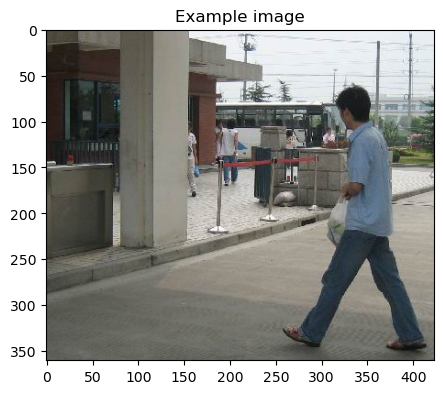

(361, 423, 3)

In [5]:
image_path = 'PennFudanPed/PNGImages/FudanPed00037.png'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.title("Example image")
plt.imshow(image)
plt.show()
np.shape(image)

In [6]:
preds = yolov8(image, classes=0) # make prediction (cls and bbx)

for pred in preds:
    detection_labels = [int(x) for x in list(pred.boxes.cls)]
    detection_boxes = [[int(x[0]), int(x[1]), int(x[2]), int(x[3])] for x in list(pred.boxes.xyxy)]


0: 576x640 3 persons, 131.6ms
Speed: 5.9ms preprocess, 131.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


# Quick Mask

(361, 423)

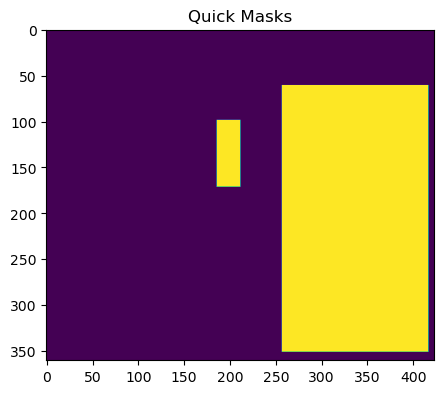

In [7]:
h = np.shape(image)[0] # size of masks
w = np.shape(image)[1]
merged_masks = np.zeros((h, w))  
for box in detection_boxes:
    mask = np.zeros((h, w))
    mask[box[1]:box[3]+1, box[0]:box[2]+1] = 1
    merged_masks = np.maximum(merged_masks, mask)
plt.figure(figsize=(5, 5))
plt.imshow(merged_masks)
plt.title("Quick Masks")
np.shape(merged_masks)

# Fine Mask

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame.

For example, here we have several bounding boxes from YOLOv8 model. Then, the boxes are transformed to the input frame, and SamPredictor predicts the masks.

`SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [8]:
input_boxes = torch.tensor(detection_boxes, device=predictor.device) # to tensor
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2]) # to the input frame

`SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

Process the image to produce an image embedding by calling `SamPredictor.set_image`. 
`SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [9]:
time_start = time.time() # record segmentation start time
predictor.set_image(image)
masks, scores, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True,
)
time_duration = time.time()-time_start # count duration
print("Segmentation is done in {:.2f} seconds.".format(time_duration))
print(masks.shape)  # (batch_size) x (num_predicted_masks_per_input) x H x W
print(scores.shape) # batch_size x num_predicted_masks_per_input

Segmentation is done in 0.81 seconds.
torch.Size([3, 3, 361, 423])
torch.Size([3, 3])


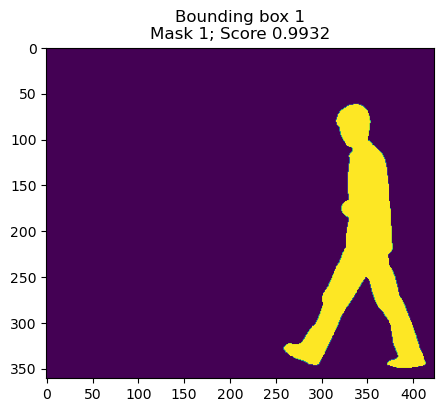

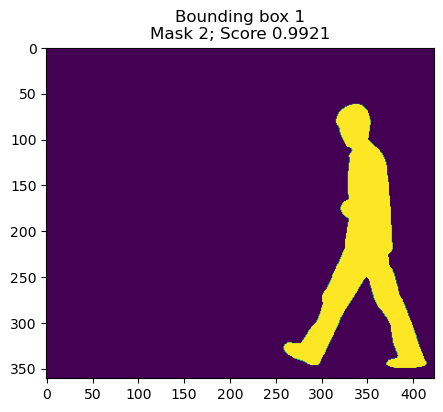

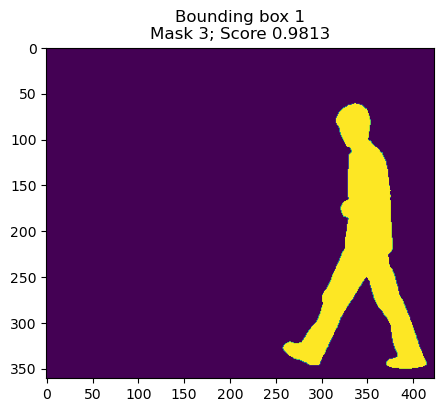

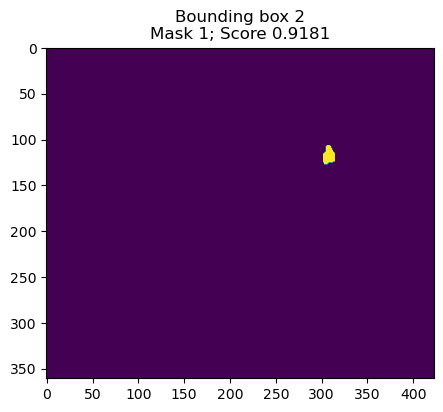

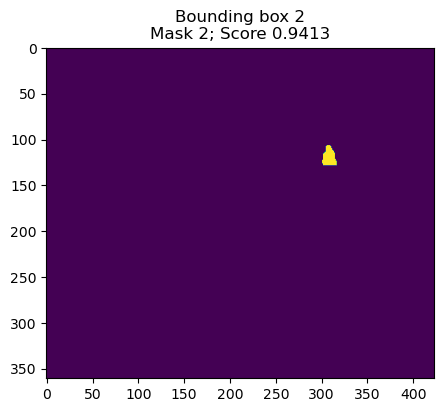

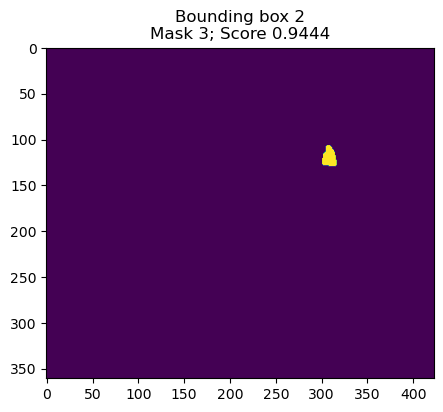

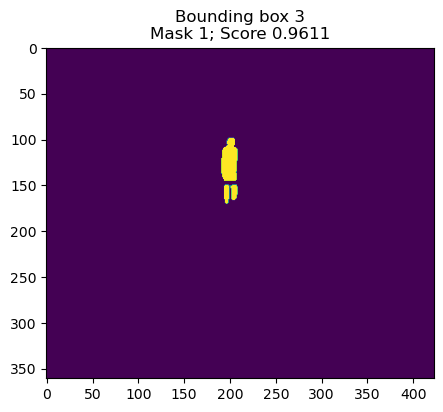

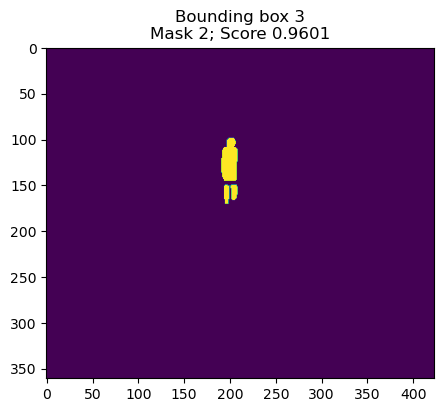

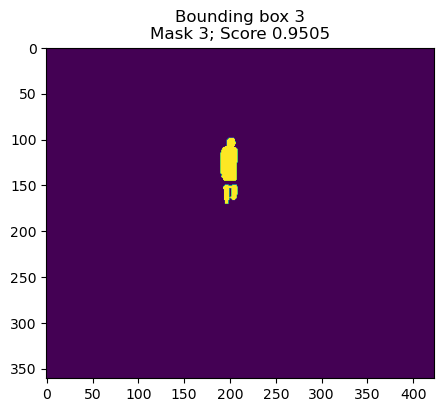

In [10]:
m, n = scores.cpu().numpy().shape
merged_masks = np.zeros_like(masks.cpu().numpy()[0,0])

# plot all masks w.r.t all bounding boxes
for i in range(m):
    for j in range(n):
        plt.figure(figsize=(5, 5))
        plt.imshow(masks.cpu().numpy()[i,j])
        merged_masks = np.maximum(merged_masks, masks.cpu().numpy()[i,j])
        # Yufan's Note: the mask is single channel, binary image, same size as the input.
        plt.title("Bounding box {}\nMask {}; Score {:.4f}".format(i+1,j+1,scores[i,j]))

(361, 423)

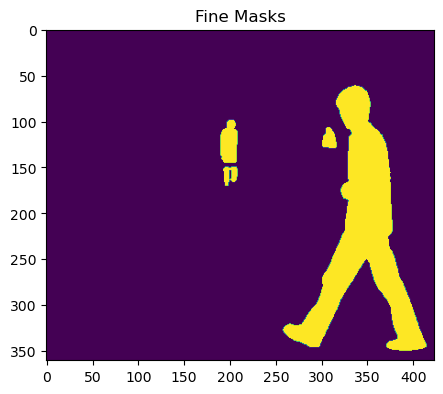

In [11]:
# merged masks
plt.figure(figsize=(5, 5))
plt.imshow(merged_masks)
plt.title("Fine Masks")
np.shape(merged_masks)

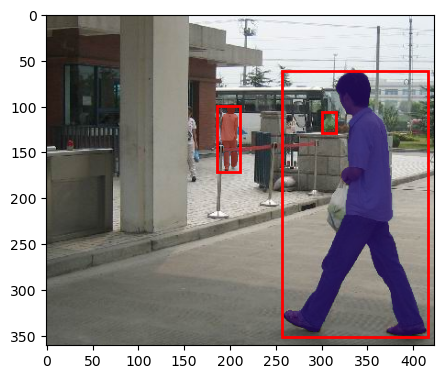

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy()[0], plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.show()